## Demo with BTK data

This walkthrough uses sims generated from the Blending Toolkit (Mendoza et al. 2025)

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

import numpy as np
import os, json, cv2, random

import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import LazyConfig
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import deepdisc.astrodet.astrodet as toolkit
from deepdisc.astrodet import detectron as detectron_addons

from deepdisc.data_format.file_io import DDLoader
from deepdisc.data_format.annotation_functions.annotate_hsc import annotate_hsc

In [2]:
# Change the path to where you've downloaded the data
dirpath = "/home/shared/hsc/DDTutorials/BTK/"  
#Change to where you want to output the model
output_dir = "/home/g4merz/test/"

dataset_names = ["train", "test"]

### Training data


We have formatted some BTK data for this demo notebook. You can find it here 

The network needs both images and metadata to train.  The metadata consists of a few image properties along with "annotations" for each object.  Annotations are dictionaries that contain information about the objects' bounding boxes, segmenation masks, class, and any other information you want to use.  

In this demo, we use data that already has annotations generated.  The preprocessing tutorial in the docs walks through using the scarlet deblender on an image dataset to produce annotations.  You can find examples of the annotation generation in the deepdisc.data_format.annotation_functions module.  For a custom dataset, you may need to change the annotation functions to properly format your metadata.  

Once created, you can save the metadata into a json file to load in later.  We will use a saved json file of metadata below



The flexible `DDLoader` class can be used create metadata from output files, or load in saved metadata.

In [3]:
# Initialize a DDLoader class, which will just be used to load existing files
json_loader = DDLoader()


dataset_dicts = {}

for i, d in enumerate(dataset_names):
    print(f"Loading {d}")
    filenames_dir = os.path.join(dirpath, d)
    filepath = filenames_dir + ".json"
    dataset_dicts[d] = json_loader.load_coco_json_file(filepath).get_dataset()
    
    
    # Lets you rerun this cell without raising an error
    if f"astro_{d}" in DatasetCatalog.list():
        DatasetCatalog.remove(f"astro_{d}")
    
    DatasetCatalog.register(f"astro_{d}", lambda: json_loader.load_coco_json_file(filepath).get_dataset())
    MetadataCatalog.get(f"astro_{d}").set(thing_classes=["galaxy"])

astrotrain_metadata = MetadataCatalog.get(f"astro_train")
astrotest_metadata = MetadataCatalog.get(f"astro_test")


Loading train
Loading test


We registered the dataset, which links a string name ("astro_train/test") to the metadata.

### A note on classes

In this demo, we assume one class for all objects.

### Dataloading and Visualization

During training, the network will randomly sample the metadata.  Each entry in the metadata dictionary correpsonds to a single image.  To save memory, the image itself is read in on-the-fly using a filepath stored in the metadata and some function to read from the disk.


All of this is wrapped into the `DictMapper` class.  The `DictMapper` has three key pieces

1. ImageReader: This class will load the image from the disk, and apply any scalings (Lupton, custom, etc.)
2. key_mapper: This will take the metadata and return a filepath (or paths) to an image.  Most of the time it will just return the filepath already stored in the metadata, but if you move the data or have one image per filter, it can be used to return the correct filepaths.
3. augmentations: These are custom data augmentations that will be applied during training 

In [4]:
#1
from deepdisc.data_format.image_readers import DC2ImageReader
reader = DC2ImageReader(norm="lupton",stretch=6000,     # ImageReader class to read the image from the disk and apply contrast scalings
                        Q=10, bandlist=[2,1,0])   
#2
def key_mapper(dataset_dict):
    key = os.path.join('/home/shared/hsc/DDTutorials/BTK/','img_'+dataset_dict['file_name'].split('_')[1]+'.npy')
    return key

#3
from deepdisc.data_format.augment_image import dc2_train_augs


In [5]:
import deepdisc.model.loaders as loaders
tm = loaders.DictMapper                                # DictMapper class to read in the dictionaries and reformat them for the model
mapper = tm(reader, key_mapper, dc2_train_augs).map_data   # Map (reformat) the data

(-0.5, 319.5, 319.5, -0.5)

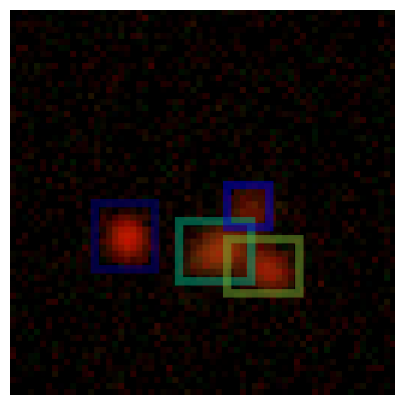

In [6]:
from detectron2.structures import BoxMode

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

dictionary = iter(dataset_dicts["train"])
d = next(dictionary)
img = reader(key_mapper(d))

visualizer = Visualizer(img, metadata=astrotrain_metadata, scale=5)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
ax.imshow(out.get_image())
ax.axis("off")


### Data Augmentation

Data augmentations can be applied during training.  We have some pre-defined basic spatial augmentaions like flips and 90 degree rotations, as well as cropping. Any function can be applied as an augmentation.  Check out the `data_format.augment_image` module for examples.  Also see the detectron2 documentation

(64, 64, 3)


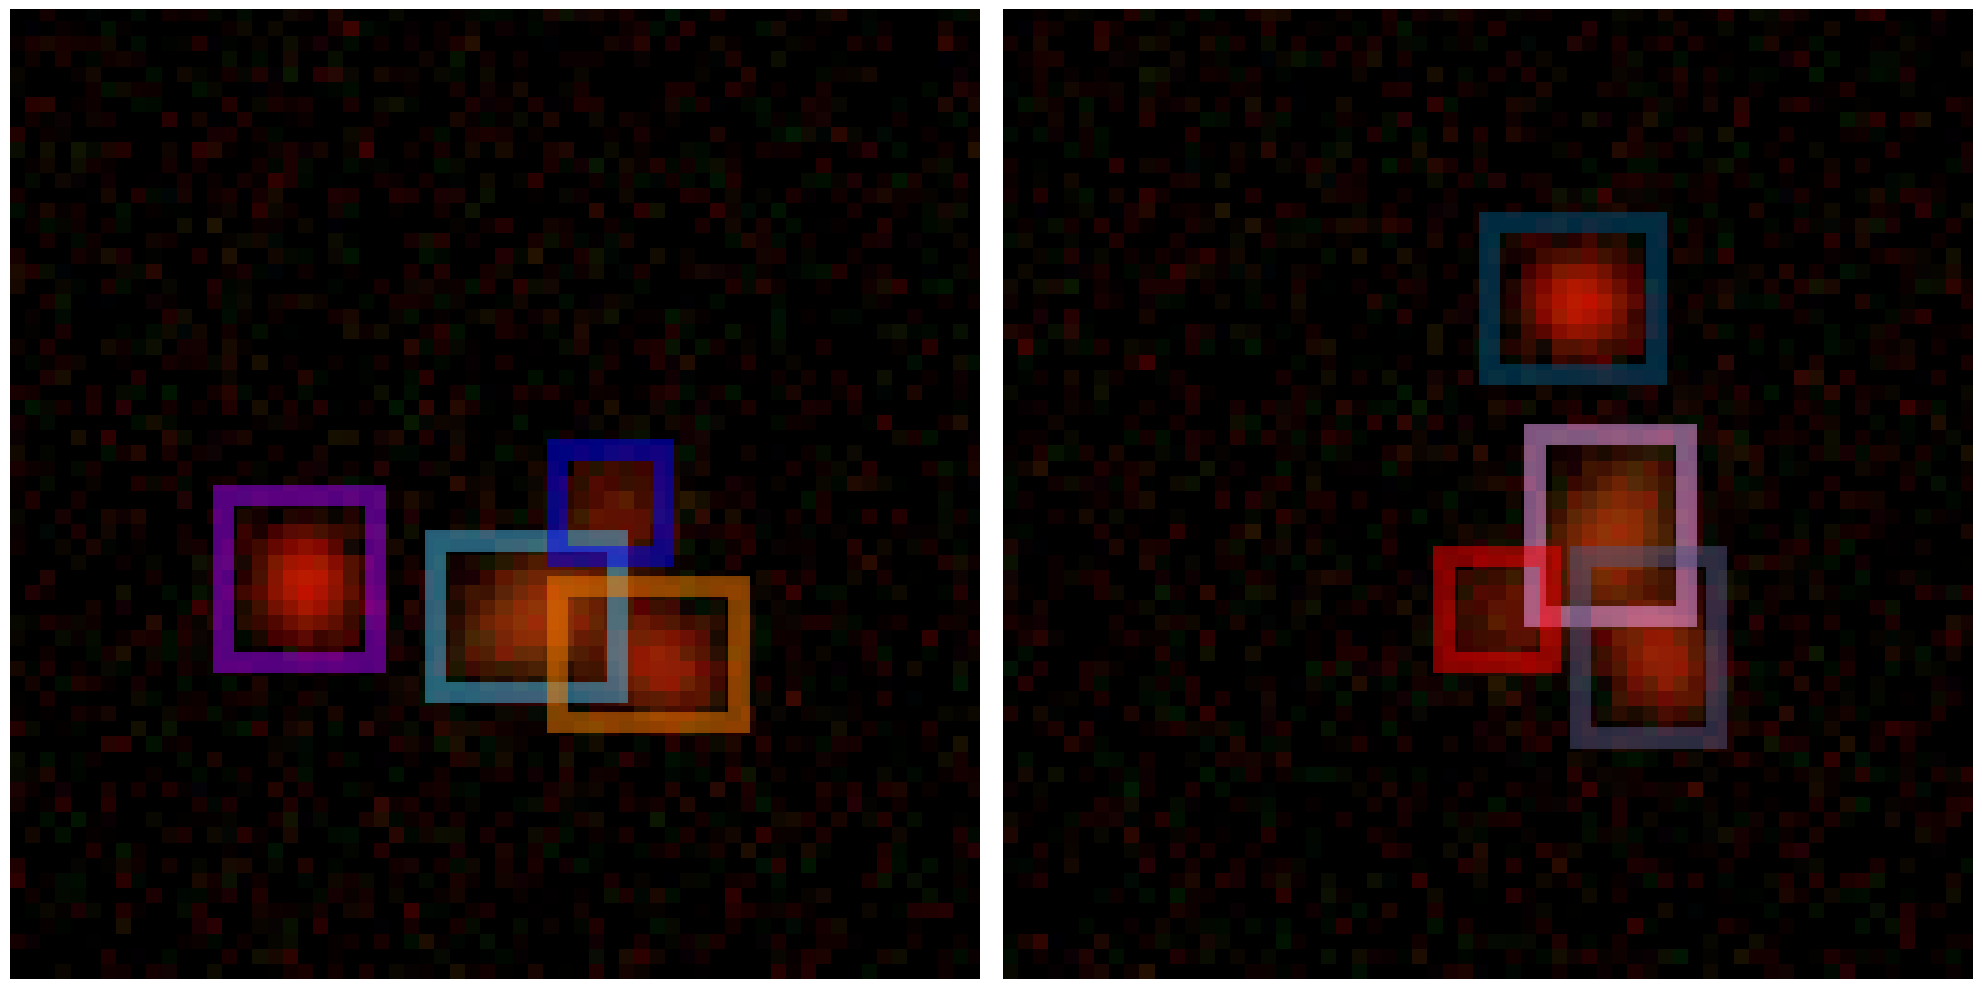

In [8]:
from detectron2.structures import BoxMode

fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 10))

dictionary = iter(dataset_dicts["train"])
d = next(dictionary)
img = reader(key_mapper(d))

visualizer = Visualizer(img, metadata=astrotrain_metadata, scale=5)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis("off")

aug_d = mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astrotrain_metadata, scale=5)
print(img_aug.shape)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis("off")
fig.tight_layout()
fig.show()

### Prepare For Training

We prepare for training by intializing a config object.  Then we can take the intial weights from the pre-trained models in the model zoo.
This setup is for demo purposes, so it does not follow a full training schedule.

We train by setting up a trainer object.  This will take a pytorch nn model, a loader (which is just the mapper from above with some detectron2 wrappings), an optimizer which sets the learning rate and scheduler, and any additional operations during training which are called "hooks".  Below, we use a hook to save the model every few iterations, and a hook that employs the learning rate scheduler

In [9]:
from deepdisc.training.trainers import (
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)

from deepdisc.model.models import return_lazy_model


In [10]:
cfgfile = '../configs/solo/demo_r50_btk.py'          # The config file which contains information about the model architecture
cfg = LazyConfig.load(cfgfile)                       # Load in the config
model = return_lazy_model(cfg,freeze=False)          # Build the model from the config specifications
cfg.optimizer.params.model = model                   # Set up the training optimizer
optimizer = return_optimizer(cfg)


cfg.OUTPUT_DIR = output_dir                          #Set the output directory

cfg.SOLVER.IMS_PER_BATCH = 4                         #Set the batch size

loader = loaders.return_train_loader(cfg, mapper)    # Set up the loader, which formats the data to be fed into the model

schedulerHook = return_schedulerhook(optimizer)             # Create a hook to set up the scheduler to control learning rates
saveHook = return_savehook("model_temp",save_period=100)    # Create a hook to save the model every 100 iterations
hookList = [saveHook, schedulerHook]                 

#Initialize the model weights from a pre-trained model
#Change this if you want to use a different pre-trained model
#cfg.train.init_checkpoint = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"   



[02/26 18:31:33 d2.data.build]: Removed 0 images with no usable annotations. 200 images left.
[02/26 18:31:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   galaxy   | 492          |
|            |              |
[02/26 18:31:33 d2.data.build]: Using training sampler TrainingSampler
[02/26 18:31:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 18:31:33 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[02/26 18:31:33 d2.data.common]: Serialized dataset takes 0.07 MiB
[02/26 18:31:33 d2.data.build]: Making batched data loader with batch_size=4


### Training may take a few minutes  

There's only a few objects per image, so we have to train for several iterations to see good results (even for the demo)

Training times will be increased if using a Swin transformer

In [11]:
trainer = return_lazy_trainer(model, loader, optimizer, cfg, hookList)
trainer.set_period(100)  # print loss every 100 iterations
trainer.train(0, 1000)   # train for 1000 iterations

[02/26 18:31:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[02/26 18:31:34 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[02/26 18:31:34 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[02/26 18:31:34 d2.engine.train_loop]: Starting training from iteration 0


/home/g4merz/.conda/envs/ddrailnv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /data/miniconda3/envs/opence-1.7/conda-bld/pytorch-base_1672876060819/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration:  100  data time:  0.00702387560158968  loss time:  0.0790714300237596 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.15153008699417114, 0.034858278930187225, 0.45567426085472107, 0.03935353457927704, 0.01000356674194336] val loss:  0 lr:  [0.001]
saving model_temp
Iteration:  200  data time:  0.010007413104176521  loss time:  0.15238127298653126 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.03507830575108528, 0.023951523005962372, 0.4531203508377075, 0.04365362226963043, 0.008552402257919312] val loss:  0 lr:  [0.001]
saving model_temp
Iteration:  300  data time:  0.00900343107059598  loss time:  0.11003752890974283 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.04734668508172035, 0.0467546246945858, 0.45967090129852295, 0.04231308400630951, 0.010463600978255272] val loss:  0 lr:  [0.001]
saving model_temp
Iteration:  400  data time:  0.0049850228242576

### Plot The Loss

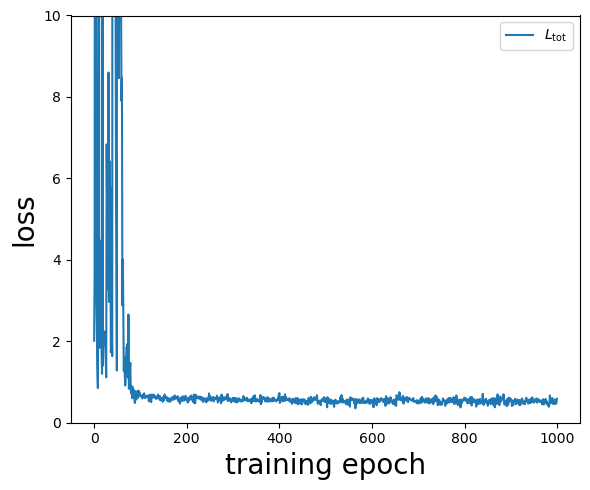

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r"$L_{\rm{tot}}$")
# ax.plot(losses, label=r'$L_{\rm{tot}}$')
ax.set_ylim(0,10)
ax.legend(loc="upper right")
ax.set_xlabel("training epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
fig.tight_layout()

### Inference

We can use the same config to load the model after training.  Just change the path to the trained model weights.  We create a predictor class to feed in the images

In [13]:
from deepdisc.inference.predictors import return_predictor


cfgfile = '../configs/solo/demo_r50_btk.py'
cfg = LazyConfig.load(cfgfile)
cfg.OUTPUT_DIR = output_dir
cfg.train.init_checkpoint = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")



#change these to play with the detection sensitivity
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.5
cfg.model.roi_heads.box_predictor.test_nms_thresh = 0.3


#if using a swin model with cascade ROI heads, change these to to play with the detection sensitivity
#for box_predictor in model.roi_heads.box_predictors:
#    box_predictor.test_score_thresh = 0.5
#    box_predictor.test_nms_thresh = 0.3


predictor = return_predictor(cfg)



[02/26 18:38:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/g4merz/test/model_temp.pth ...


total instances: 4
detected instances: 3



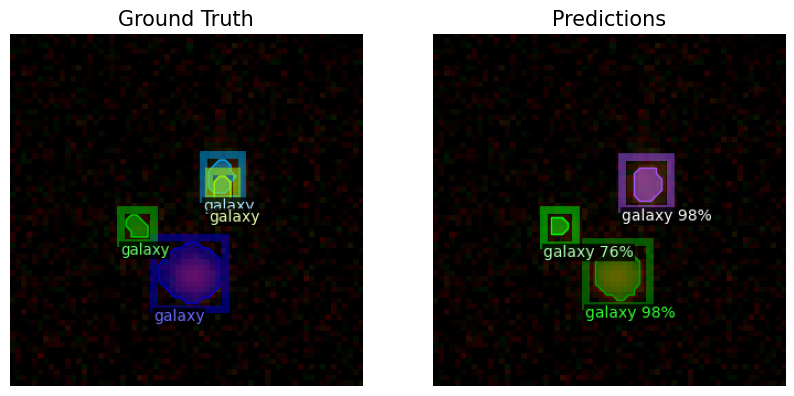

In [16]:
from detectron2.utils.visualizer import ColorMode

nsample = 1
fig = plt.figure(figsize=(10, 5 * nsample))

for i, d in enumerate(random.sample(dataset_dicts["test"], nsample)):
    img = reader(key_mapper(d))
    print("total instances:", len(d["annotations"]))
    v0 = Visualizer(
        img,
        metadata=astrotest_metadata,
        scale=5,
        instance_mode=ColorMode.SEGMENTATION,
    )
    groundTruth = v0.draw_dataset_dict(d)

    ax1 = plt.subplot(nsample, 2, 2 * i + 1)
    ax1.imshow(groundTruth.get_image())
    ax1.axis("off")
    ax1.set_title('Ground Truth',fontsize=15)


    v1 = Visualizer(
        img,
        metadata=astrotest_metadata,
        scale=5,
        instance_mode=ColorMode.SEGMENTATION,
    )
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    print("detected instances:", len(outputs["instances"].pred_boxes))
    print("")
    ax1 = plt.subplot(nsample, 2, 2 * i + 2)
    ax1.imshow(out.get_image())
    ax1.axis("off")
    ax1.set_title('Predictions',fontsize=15)

This demo is just to show how to set up the training.  We encourage you to add object classes, try different contrast scalings, and train for longer!  


    
  
  You can also look at the content of the output below  
  
  

In [37]:
outputs['instances'].get_fields().keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

Try to rerun with a different model.  You can do this by using the config in `/configs/solo/demo_swin_btk.py`  

If you want to use a pre-trained model as a starting point with this config, you will need to download it here https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/cascade_mask_rcnn_swin_b_in21k/f342979038/model_final_246a82.pkl  

You will need to change the `cfg.train.init_checkpoint` to the path of the downloaded pre-trained model  
